### Eye Detection of Ancient Statues

Here is a simple tutorial on detecting eyes of ancient statues.

We will mostly use ancient greek and egyptian statues, but same principals apply to any statue litterally.

We will also observe some of the key points during the detection process.

####  The Packages

The goal of this tutorial is NOT to introduce to the user to cutting edge technology.
Rather we try to show what can be easily applied to get some initial results.

We import packages as the following

In [1]:
import numpy as np # used for numerical analysis
import cv2 # python bindings of the comprehensive computer vision package opencv
import matplotlib.pyplot as plt # for visualizing our results in the notebook
import glob # for obtaining paths of the images in our dataset

Let's load the images in a list

In [2]:
# Reading the images from the path
image_folder = "./images/"
images_paths = glob.glob(image_folder+"*.jpg") # creates a list of paths from the folder
images = [cv2.imread(path) for path in images_paths] # loads the images in the path as ndarray

Here is a simple function to visualize a list of images

In [3]:
def show_images(images, 
               cols = 1, 
               titles = None,
               cmap="gray",
               title_color="yellow"):
    """Display a list of images in a single figure with matplotlib.
    
    code slightly modified from:
    https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: 
        titles = ['Image {}'.format(str(i))  for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.imshow(image, cmap=cmap)
        a.set_title(title, color=title_color)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

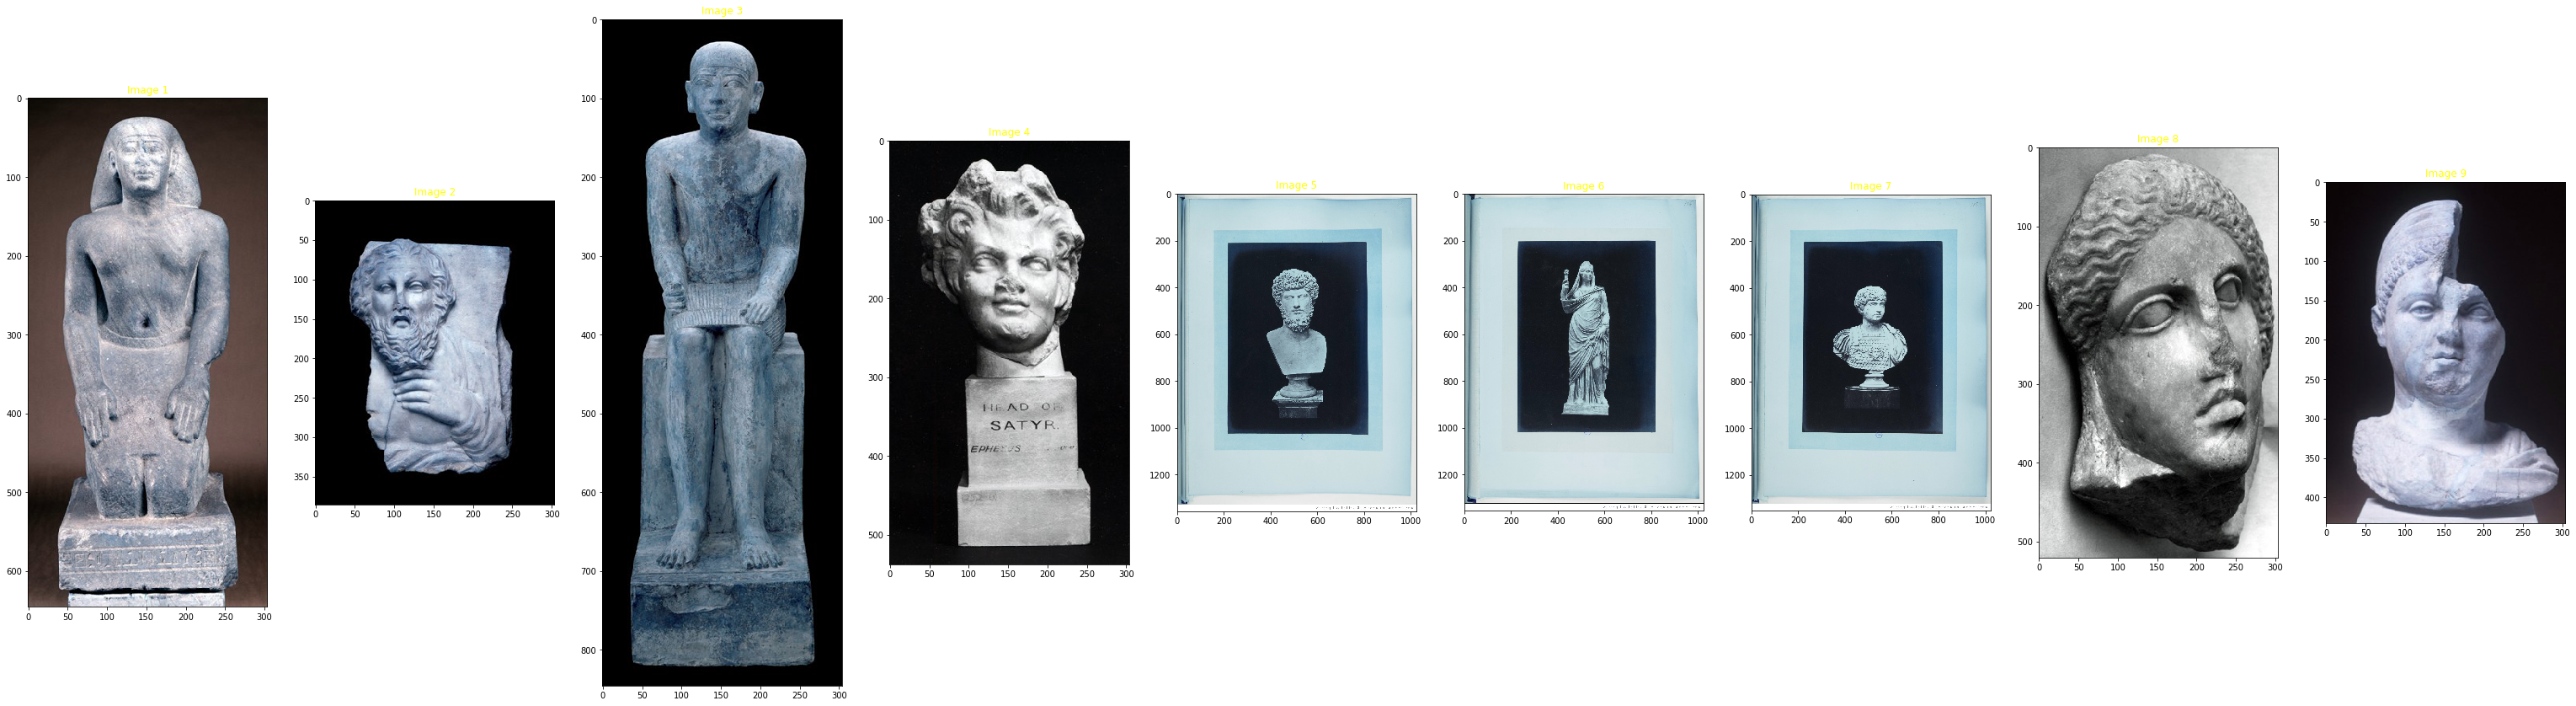

In [4]:
# Show original images
show_images(images)

Let's try to detect the face of a single statue first before going for the eye.

We are using a [haar cascade](https://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html).

You can download the detector from [here](https://github.com/opencv/opencv/tree/master/data/haarcascades)

For the parameters of `detectMultiScale`, see opencv [docs](https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html?highlight=detectmultiscale#cascadeclassifier-detectmultiscale)

In [5]:
# Single Image Example

image = images[3] # selecting an image from the image list

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting to the image to grayscale 

face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
# Loading the opencv cascade classifier which is in the folder 'detectors'

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, # image 
                                      1.25, # scale factor
                                      6 # minNeighbor
                                     )

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

Number of faces detected: 1


Now let's focus on the eye

In [6]:
image_cp = np.copy(image)
#
eye_cascade = cv2.CascadeClassifier("detectors/haarcascade_eye.xml")


for (x,y,w,h) in faces:
    cv2.rectangle(image_cp, (x,y), (x+w,y+h),(255,0,0), 3)
    roi = image_cp[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi, 1.099, 1)
    print("detected eyes: ", str(len(eyes)))
    for nx,ny,nw,nh in eyes:
        cv2.rectangle(roi,
                      (nx,ny),(nx+nw, ny+nh),
                     (0,255,0), 2)

detected eyes:  4


Let's see our detected eye

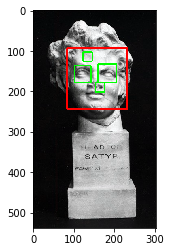

In [7]:
plt.imshow(image_cp)

As you can see, it does not work so well. 

However even this rough classification can be of use.

Let's see if we can improve it by several other processes.

Let's write a function for eye detection for easy streamlining

In [8]:
def draw_faceEyeBox(image, 
                    faces,
                    eye_cascade,
                    eye_scale=1.1,
                    eye_neighbor=2,
                    faceboxcolor=(255,0,0),
                    eyeboxcolor=(0,255,0)
                    ):
    "Draws a bounding box around the image"
    img = np.copy(image)
    #
    for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
        cv2.rectangle(img, 
                      (x,y), (x+w,y+h),
                      faceboxcolor, 3)
        roi = img[y:y+h, x:x+w]
        if eye_scale is None and eye_neighbor is None:
            eyes = eye_cascade.detectMultiScale(roi)
        else:
            eyes = eye_cascade.detectMultiScale(roi, 
                                            eye_scale,
                                            eye_neighbor)
        for nx,ny,nw,nh in eyes:
            cv2.rectangle(roi,
                          (nx,ny),(nx+nw, ny+nh),
                          (0,255,0), 2)
    return img

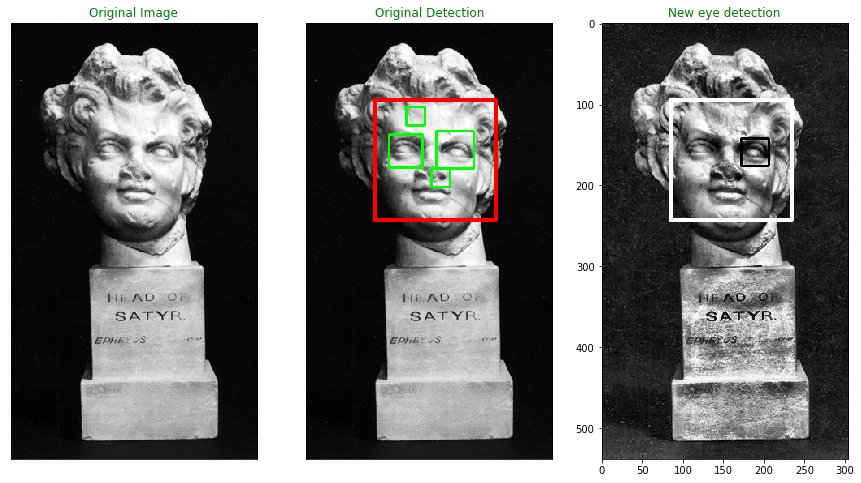

In [9]:
# Perform Canny edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting to the image to grayscale 

clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10,10))
edges = clahe.apply(gray)

eyedetect = draw_faceEyeBox(edges,
                            faces,
                            eye_cascade,
                            eye_scale=1.30,
                            eye_neighbor=1)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(131)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image', color='green')
ax1.imshow(image)

ax2 = fig.add_subplot(132)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Original Detection', color='green')
ax2.imshow(image_cp, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_title("New eye detection", color='green')
ax3.imshow(eyedetect, cmap='gray')

Let's document our pipeline in a function for the reduced eyedetection.

In [10]:
def reduced_faceEyeBox(image, faces, 
                       eye_cascade,
                      eye_scale=1.25,
                      eye_neighbor=4):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting to the image to grayscale 
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10,10))
    edges = clahe.apply(gray)
    eyedetect = draw_faceEyeBox(edges,
                                faces,
                                eye_cascade,
                                eye_scale=eye_scale,
                                eye_neighbor=eye_neighbor)
    return eyedetect

As we can see on one hand we have a pipeline 
that detects 1 correct eye, and on the other hand 
we have a pipeline that detects multiple region of interest with some errors.

Now we can try to combine them together and try different algorithms, but let's try changing the data set we had used first.

In [11]:
new_eyecascade = cv2.CascadeClassifier('detectors/haarcascade_eyeglasses.xml')

normal_detection = draw_faceEyeBox(gray, 
                                   faces, 
                                   eye_cascade=new_eyecascade,
                                   eye_neighbor=1,
                                   eye_scale=1.099)
reduced = reduced_faceEyeBox(image, 
                             faces, 
                             new_eyecascade,
                             eye_neighbor=2,
                             eye_scale=1.002
                            )

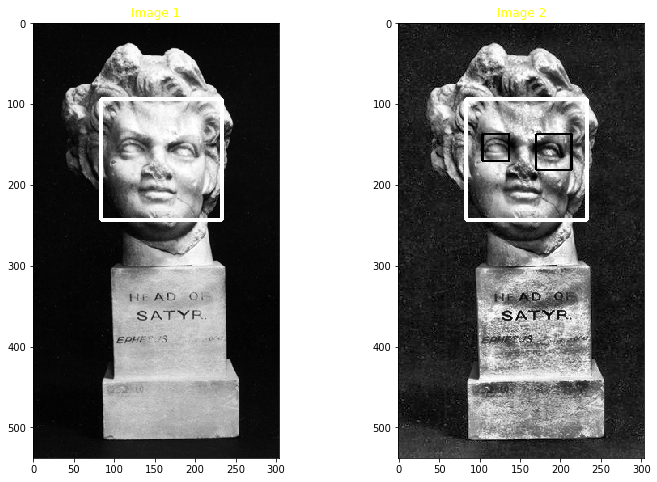

In [12]:
show_images([normal_detection, reduced])

Yes! We have sucessfully detected both eyes of the statue. Let's see how it works on other statues.

In [17]:
# multiple images
grays = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
faces = [face_cascade.detectMultiScale(gray, 1.25, 4) for gray in grays]
eye_cascade = cv2.CascadeClassifier("detectors/haarcascade_eyeglasses.xml")

In [22]:
# Draw boxes
img_faceeyes = [
    reduced_faceEyeBox(image, face,eye_cascade, eye_neighbor=3, eye_scale=1.003) for face, image in zip(faces, images)
]

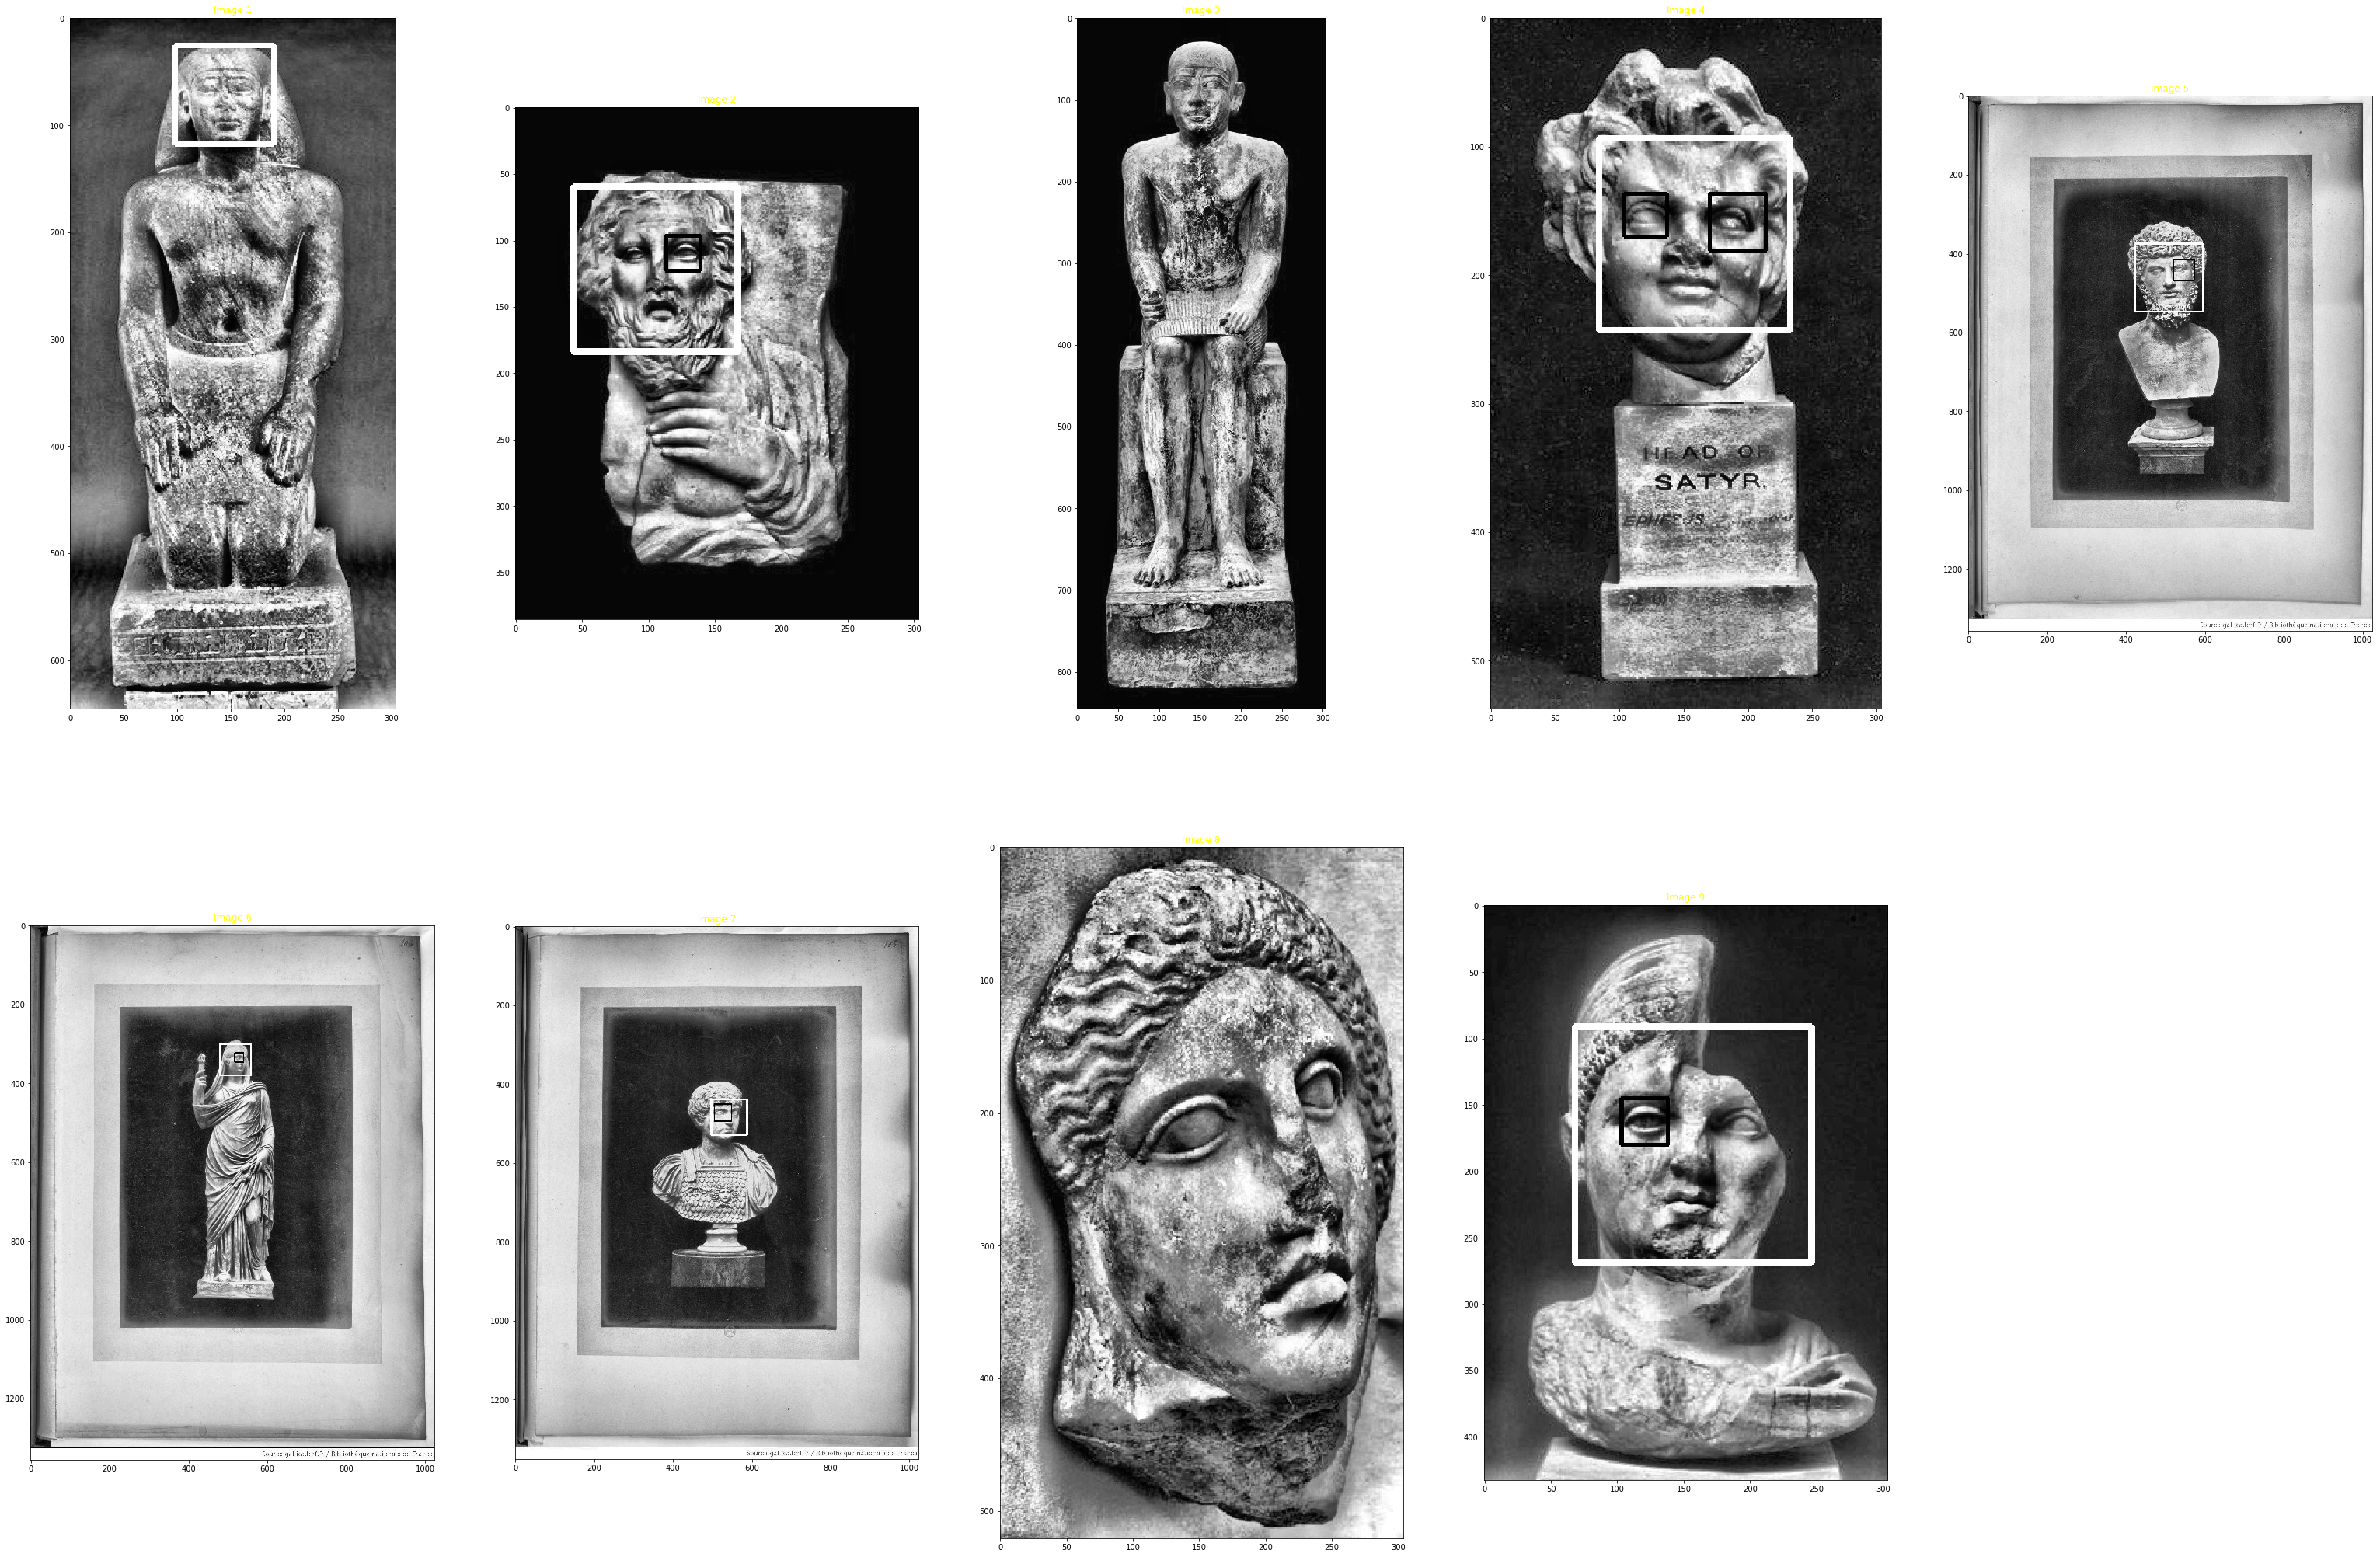

In [23]:
show_images(img_faceeyes, cols=2)